In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(42)
torch.manual_seed(0)

# Data preparation

5 (60000, 28, 28)


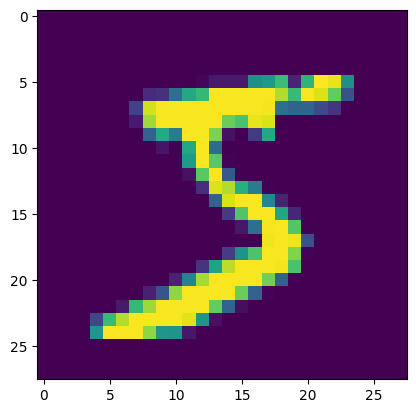

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(y_train[0], X_train.shape)
plt.imshow(X_train[0])

7 (10000, 28, 28)


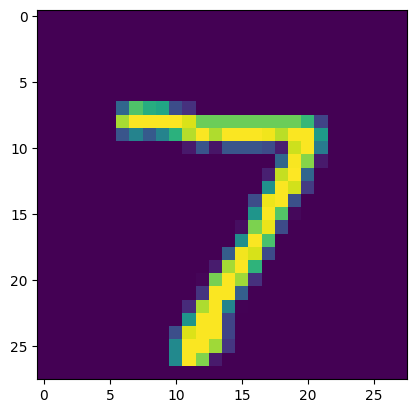

In [4]:
print(y_test[0], X_test.shape)
plt.imshow(X_test[0])

### Data reduction

In [5]:
# I will leave only two classes: zeroes and ones
train_idxs = np.logical_or(y_train == 1, y_train == 0)
X_train = X_train[train_idxs]
y_train = y_train[train_idxs]
test_idxs = np.logical_or(y_test == 1, y_test == 0)
X_test = X_test[test_idxs]
y_test = y_test[test_idxs]


In [6]:
y_test = y_test.reshape(1, -1)[0]
print("y_test:", y_test)
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)
X_train= X_train.astype('float64')
X_train/=255
X_test= X_test.astype('float64')
X_test/=255
# Needed to reduce the working time
X_train = X_train[:2000]
y_train = y_train[:2000]
X_test = X_test[:400]
y_test = y_test[:400]
print("X_train:", X_train)

y_test: [1 0 1 ... 1 0 1]
X_train: [[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0

# My model

To perform this task, I decided to structure the code in the form of classes for each type of layer, because it help avoid mess in code.

In [7]:
class Layer:
  '''
  Abstract class for maintaining the correctness of neural network layers
  '''
  def forward(self, x, no_grad=False):
    raise NotImplementedError("Forward method is not implemented!")

  def backward(self, x):
    raise NotImplementedError("Backward method is not implemented!")

  def step(self, learning_rate: float):
    raise NotImplementedError("Make step method is not implemented!")

  def zero_grad(self):
    raise NotImplementedError("Zero grad method is not implemented!")

In [8]:
class ReLULayer(Layer):
  '''
  The ReLU layer doesn't have any parameters because of that step and zero_grad methods do nothing.
  '''
  def __init__(self):
    self.forward_x = np.empty(1)

  def forward(self, x, no_grad=False):
    if not no_grad:
      self.forward_x = np.copy(x)
    x[x < 0] = 0
    return x

  def backward(self, x):
    """
    x: Upstream gradient
    Returns downstream gradient
    """
    x[self.forward_x < 0] = 0
    return x

  def step(self, learning_rate: float):
    pass

  def zero_grad(self):
    pass

In [9]:
class VectorizeLayer(Layer):
  '''
  The Vectorize layer doesn't have any parameters because of that step and zero_grad methods do nothing.
  '''
  def forward(self, x, no_grad=False):
    if not no_grad:
      self.input_shape = x.shape
    return x.reshape(-1, 1)

  def backward(self, x):
    """
    x: Upstream gradient
    Returns downstream gradient
    """
    return x.reshape(self.input_shape)

  def step(self, learning_rate: float):
    pass

  def zero_grad(self):
    pass

In [10]:
class NormalizationLayer(Layer):
  '''
  The Normalization layer doesn't have any parameters because of that step and zero_grad methods do nothing.
  '''
  def __init__(self):
      self.max_abs_value = None

  def forward(self, x, no_grad=False):
      if not no_grad:
        self.max_abs_value = np.max(np.abs(x))
      return x / np.max(np.abs(x))

  def backward(self, x):
      # Since the layer only scales by a constant (max_abs_value), the gradient is just x / max_abs_value
      return x / self.max_abs_value

  def step(self, learning_rate: float):
    pass

  def zero_grad(self):
    pass

In [11]:
class SoftmaxLayer(Layer):
  '''
  The Softmax layer doesn't have any parameters because of that step and zero_grad methods do nothing.
  '''
  def __init__(self):
    self.forward_x = None

  def forward(self, x, no_grad=False):
    if not no_grad:
      self.forward_x = x
    exp_X = np.exp(x)
    return exp_X / np.sum(exp_X)

  def backward(self, x):
    """
    x: Upstream gradient
    Returns downstream gradient
    """
    dL_dY = x

    Y = self.forward(self.forward_x, True)
    N = len(Y)
    dZ_dX = np.empty([N, N])

    # Compute the diagonal and off-diagonal elements of the dZ_dX matrix
    for i in range(N):
        for j in range(i, N):
            # I obtain the following equalities when I manually calculate derivatives.
            if i != j:
                dZ_dX[i][j] = -Y[i] * Y[j]
                dZ_dX[j][i] = dZ_dX[i][j] # Because matrix is symmetric
            else:
                dZ_dX[i][i] = Y[i] * (1 - Y[i])

    # Apply chain rule
    dL_dX = np.matmul(dZ_dX, dL_dY)
    return dL_dX.reshape(-1, 1)

  def step(self, learning_rate: float):
    pass

  def zero_grad(self):
    pass

In [12]:
class ConvolutionalLayer(Layer):

  def __init__(self, in_shape, out_channels=3, filter_size=3):
      self.in_channels, self.input_height, self.input_width = in_shape
      self.out_channels = out_channels
      self.filter_size = filter_size
      self.output_shape = (out_channels,
                           self.input_height - filter_size + 1,
                           self.input_width - filter_size + 1
                          )

      self.filter_grads = np.zeros((out_channels, self.in_channels, filter_size, filter_size))
      self.filters = np.random.uniform(-1., 1., (out_channels, self.in_channels, filter_size, filter_size))

      self.bias = np.random.uniform(-1., 1., (self.output_shape))
      self.bias_grad = np.zeros(self.output_shape)

      self.forward_x = None # Indicate the last forwarding value. Need to calculate backward values.
      self.n_samples = 0 # Indicate the numbers of forwarding and backwarding samples. Need to calculate mean gradient vector to take step

  @staticmethod
  def pad(mtr, row_pad, col_pad):
    '''
    mtr: matrix that will be padded
    row_pad: width of padding for row axis
    col_pad: width of padding for column axis
    '''
    if mtr.shape[0] == 1:
      mtr = mtr[0]
    mtr = np.concatenate((np.zeros((mtr.shape[0], col_pad)), mtr, np.zeros((mtr.shape[0], col_pad))), axis=1)
    mtr = np.concatenate((np.zeros((row_pad, mtr.shape[1])), mtr, np.zeros((row_pad, mtr.shape[1]))), axis=0)
    mtr = mtr.reshape(1, *mtr.shape)
    return mtr

  @staticmethod
  def rotate_180(mtr):
    '''
    Rotate matrix by 180 degrees
    '''
    mtr = mtr[::-1, ::-1]
    return mtr

  @staticmethod
  def conv(X, W):
    '''
    X: numpy array that represent matrix to which we will apply convolution, using filter W. It has size (D_x, H_x, W_x) - depth, height, width correspondingly
    W: numpy array that represent filter that has size (D_w, H_w, W_w) - depth, height, width correspondingly

    D_x must be equal to D_w

    Output: matrix Z that has size - (1, H_x - H_w + 1, W_x - W_w + 1)
    '''
    if(len(X.shape) == 2):
      X = X.reshape(1, *X.shape)
    if(len(W.shape) == 2):
      W = W.reshape(1, *W.shape)
    D_x, H_x, W_x = X.shape
    D_w, H_w, W_w = W.shape
    if D_x != D_w:
      raise Exception(f"Depth of the both matrices must be equal, but depth of X equal to {D_x} and depth of W equal to {D_w}")
    H_z = H_x - H_w + 1
    W_z = W_x - W_w + 1
    Z = np.empty((H_z, W_z))
    for i in range(H_z):
      for j in range(W_z):
        Z[i][j] = np.sum(X[:, i:i+H_w, j:j+W_w] * W)
    return Z

  def forward(self, x, no_grad=False):
    # no_grad indicate that we will consider this x when we will do back propagation or not
    # For example, no_grad equal to True needed when we testing our model.
    if not no_grad:
      self.n_samples += 1
      self.forward_x = x
    res = np.empty(self.output_shape)
    for i in range(self.out_channels):
      res[i] = self.conv(x, self.filters[i])
    res += self.bias
    return res

  def backward(self, x):
    """
    x: Upstream gradient
    Returns downstream gradient
    """
    self.bias_grad += x # Pass the bias node

    # Calculate gradient for filters
    for filter_i in range(self.out_channels):
      for depth in range(self.in_channels):
        self.filter_grads[filter_i][depth] += self.conv(self.forward_x[depth], x[filter_i])

    # Calculate the downstream gradient
    output_backward = np.zeros((self.in_channels, self.input_height, self.input_width))
    for gamma in range(self.in_channels):
      for i in range(self.out_channels):
        output_backward[gamma] += self.conv(self.pad(x[i], self.filter_size - 1, self.filter_size  - 1), self.rotate_180(self.filters[i][depth]))

    return output_backward

  def step(self, learning_rate: float):
   self.filters -= learning_rate * (self.filter_grads / self.n_samples)
   self.bias -= learning_rate * (self.bias_grad / self.n_samples)

  def zero_grad(self):
    self.filter_grads = np.zeros((self.out_channels, self.in_channels, self.filter_size, self.filter_size))
    self.bias_grad = np.zeros(self.output_shape)
    self.n_samples = 0
    self.forward_x = None

In [13]:
class LinearLayer(Layer):
  def __init__(self, in_size, out_size):
    self.in_size = in_size
    self.out_size = out_size
    self.W = np.random.uniform(-1., 1., (out_size, in_size))
    self.W_grad = np.zeros((out_size, in_size))
    self.bias = np.random.uniform(-1., 1., (out_size, 1))
    self.bias_grad = np.zeros((out_size, 1))
    self.forward_x = None
    self.n_samples = 0

  def forward(self, x, no_grad=False):
    # no_grad indicate that we will consider this x when we will do back propagation or not
    # For example, no_grad equal to True needed when we testing our model.
    if not no_grad:
      self.n_samples += 1
      self.forward_x = x
    return np.matmul(self.W, x) + self.bias

  def backward(self, x):
    """
    x: Upstream gradient
    Returns downstream gradient
    """
    # Backprogate through bias node
    self.bias_grad += x

    # Calculate gradient for W matrix
    dL_dW = np.empty(self.W.shape)
    n, k = self.W.shape
    for i in range(n):
      for j in range(k):
        dL_dW[i][j] = np.dot(x[i], self.forward_x[j]) # It's equality we can easily get if we multiply correct all corresponding derivatives
    self.W_grad += dL_dW

    # Calculate downstream gradient
    dL_dX = np.empty(self.forward_x.shape)
    n, k = self.forward_x.shape
    for i in range(n):
      for j in range(k):
        dL_dX[i][j] = np.dot(x[:, j], self.W[:, i]) # It's equality we can easily get if we multiply correct all corresponding derivatives
    return dL_dX

  def step(self, learning_rate: float):
    self.W -= learning_rate * (self.W_grad / self.n_samples)
    self.bias -= learning_rate * (self.bias_grad / self.n_samples)

  def zero_grad(self):
    self.W_grad = np.zeros(self.W.shape)
    self.bias_grad = np.zeros((self.out_size, 1))
    self.n_samples = 0
    self.forward_x = None

In [14]:
class Model:
  def __init__(self, layers):
    self.layers = layers

    # no_grad indicate that we will consider this x when we will do back propagation or not
    # For example, no_grad equal to True needed when we testing our model.
    self.no_grad = False

  def forward(self, x):
    for layer in self.layers:
      x = layer.forward(x, self.no_grad)
    return x

  def backward(self, up_stream_gradient):
    for layer in self.layers[::-1]:
      up_stream_gradient = layer.backward(up_stream_gradient)

  def step(self, learning_rate):
    for layer in self.layers:
      layer.step(learning_rate)

  def zero_grad(self):
      for layer in self.layers:
        layer.zero_grad()

  def predict(self, x):
    x = self.forward(x)
    return np.argmax(x)

In [15]:
num_labels = 2
conv1 = ConvolutionalLayer(X_train[0].shape, out_channels=1)
conv2 = ConvolutionalLayer(conv1.output_shape, out_channels=1)
layers = [
         conv1, ReLULayer(),
         conv2, ReLULayer(),
         VectorizeLayer(),
         LinearLayer(np.prod(conv2.output_shape), 10), ReLULayer(),
         LinearLayer(10, num_labels), ReLULayer(),
         SoftmaxLayer()
         ]
model = Model(layers)

In [16]:
def training(model, X_train, y_train, X_test, y_test, batch_size, learning_rate, epoch):
  for i in range(epoch):
    cur_idx = 0
    print(f"Epoch {i}:\n----------------------------")
    batch_N = 0
    while len(X_train) - cur_idx >= batch_size:
      batch_loss = 0
      acc = 0
      for i in range(cur_idx, min(cur_idx + batch_size, len(X_train))):
        sample = X_train[i]
        probs = model.forward(sample)
        prediction = np.argmax(probs)

        acc += prediction == y_train[i]
        batch_loss += -np.log(probs[y_train[i]])

        start_backward = np.zeros(len(probs), dtype=float)
        start_backward[y_train[i]] = -1 / probs[y_train[i]] # derivative of loss function
        model.backward(start_backward)

      cur_idx = min(cur_idx + batch_size, len(X_train))
      model.step(learning_rate)
      model.zero_grad()
      print(f"Training batch {batch_N}:\n\t", end='')
      print("loss:", batch_loss / batch_size, "| accuracy:", acc / batch_size)
      batch_N += 1
      # print("Validation:\n\t", end='')
      # testing(model, X_test, y_test)

def testing(model, X_test, y_test):
  acc = 0
  avg_loss = 0
  model.no_grad = True
  for i, sample in enumerate(X_test):
    probs = model.forward(sample)
    avg_loss += -np.log(probs[y_test[i]])
    acc += np.argmax(probs) == y_test[i]
  model.no_grad = False
  print("loss:", avg_loss / len(X_test), "| accuracy:", acc / len(X_test))

In [17]:
batch_size=80
learning_rate=0.01
epoch = 2

In [18]:
training(model, X_train, y_train, X_test, y_test, batch_size=batch_size, learning_rate=learning_rate, epoch=epoch)

Epoch 0:
----------------------------
Training batch 0:
	loss: [3.4984845] | accuracy: 0.55
Training batch 1:
	loss: [1.45501513] | accuracy: 0.55
Training batch 2:
	loss: [0.65006088] | accuracy: 0.65
Training batch 3:
	loss: [0.77687364] | accuracy: 0.5875
Training batch 4:
	loss: [0.73136194] | accuracy: 0.625
Training batch 5:
	loss: [0.75558968] | accuracy: 0.6875
Training batch 6:
	loss: [0.64017649] | accuracy: 0.6625
Training batch 7:
	loss: [0.6859961] | accuracy: 0.575
Training batch 8:
	loss: [0.52210708] | accuracy: 0.775
Training batch 9:
	loss: [0.57417589] | accuracy: 0.7125
Training batch 10:
	loss: [0.56735528] | accuracy: 0.7125
Training batch 11:
	loss: [0.62525991] | accuracy: 0.6875
Training batch 12:
	loss: [0.62082444] | accuracy: 0.6875
Training batch 13:
	loss: [0.60324726] | accuracy: 0.7125
Training batch 14:
	loss: [0.50675374] | accuracy: 0.775
Training batch 15:
	loss: [0.52482563] | accuracy: 0.75
Training batch 16:
	loss: [0.46319969] | accuracy: 0.8375


In [19]:
testing(model, X_test, y_test)

loss: [0.23642654] | accuracy: 0.935


# The same pytorch model

Unfortunately, pytoch conv2d layer bias term logic doesn't works like convolution node bias term that was I implemented, because size of  pytorch conv2d bias term is num_channels x 1 x 1(For each channel, it add one number that corresponded to this channel). So, to check that forward and backward propagation work identical I make zero all convolutional bias terms for both models: for mine and torch model. And then I compare results of forward propagation, and backward propagation for all parameters of both models.

In [20]:
import torch
import torch.nn as nn

class TorchModel(nn.Module):
    def __init__(self, num_labels, conv1_weight, conv2_weight, linear1_weight, linear1_bias, linear2_weight, linear2_bias):
        super(TorchModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0)
        self.relu2 = nn.ReLU()
        self.vectorize = nn.Flatten()
        self.linear1 = nn.Linear(24*24, 10)
        self.relu3 = nn.ReLU()
        self.linear2 = nn.Linear(10, num_labels)
        self.relu4 = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        # Set my own weights and biases for each layer

        self.conv1.weight = nn.Parameter(conv1_weight)
        self.conv1.bias = nn.Parameter(torch.zeros(self.conv2.bias.shape).double())
        self.conv2.weight = nn.Parameter(conv2_weight)
        self.conv2.bias = nn.Parameter(torch.zeros(self.conv2.bias.shape).double())

        self.linear1.weight = nn.Parameter(linear1_weight)
        self.linear1.bias = nn.Parameter(linear1_bias.reshape(1, 10))

        self.linear2.weight = nn.Parameter(linear2_weight)
        self.linear2.bias = nn.Parameter(linear2_bias.reshape(1, 2))

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.vectorize(x)
        x = self.linear1(x)
        x = self.relu3(x)
        x = self.linear2(x)
        x = self.relu4(x)
        x = self.softmax(x)
        return x


## Checking  that the pytorch model and mine are identical

### Preparing our pytorch model
We have to make the parameters the same for pytorch model and mine


In [21]:
x = X_train[0]
y = y_train[0]
conv1_weight = torch.from_numpy(model.layers[0].filters.astype(np.float64))
model.layers[0].bias.fill(0.)
conv2_weight = torch.from_numpy(model.layers[2].filters.astype(np.float64))
model.layers[2].bias.fill(0.)
linear1_weight = torch.from_numpy(model.layers[5].W.astype(np.float64))
linear1_bias = torch.from_numpy(model.layers[5].bias.astype(np.float64))
linear2_weight = torch.from_numpy(model.layers[7].W.astype(np.float64))
linear2_bias = torch.from_numpy(model.layers[7].bias.astype(np.float64))

torch_model = TorchModel(num_labels, conv1_weight, conv2_weight, linear1_weight, linear1_bias, linear2_weight, linear2_bias)

### Checking that forward propagation is the same

In [22]:
torch_output = torch_model.forward(torch.from_numpy(x).to(torch.float64))[0]

my_output = model.forward(x)
mae = (np.abs(torch_output.detach().numpy() - my_output.T)).mean()
print("MAE for mine forward propagation output and pytorch output:", mae)

MAE for mine forward propagation output and pytorch output: 2.7755575615628914e-17


### Checking that backward propagation is same for both models
To be sure about this, I just compare all learnable parameters for both models. For that purpose, I use mean absolute error.


In [23]:
target = torch.zeros(torch_output.shape)
target[y] = 1.
loss = torch.sum(-torch.log(torch_output) * target)

loss.backward()
# Calculate backward for loss and do back propagation for my model
start_backward = target.numpy()
start_backward /= -my_output[y] # loss derivative
start_backward = start_backward.reshape(-1, 1)
model.backward(start_backward)

conv1_weight_grad = torch_model.conv1.weight.grad
print("MAE for first convolutional layer parameters:", np.sum(np.abs(conv1_weight_grad.numpy() - model.layers[0].filter_grads)))

conv2_weight_grad = torch_model.conv2.weight.grad
print("MAE for second convolutional layer parameters:", np.sum(np.abs(conv2_weight_grad.numpy() - model.layers[2].filter_grads)))

linear1_weight_grad = torch_model.linear1.weight.grad
linear1_bias_grad = torch_model.linear1.bias.grad

print("MAE for first linear layer parameters:",
      np.sum(np.abs(linear1_weight_grad.numpy() - model.layers[5].W_grad))
      + np.sum(np.abs(linear1_bias_grad.numpy() - model.layers[5].bias_grad.T)))

linear2_weight_grad = torch_model.linear2.weight.grad
linear2_bias_grad = torch_model.linear2.bias.grad

print("MAE for second linear layer parameters:",
      np.sum(np.abs(linear2_weight_grad.numpy() - model.layers[7].W_grad))
      + np.sum(np.abs(linear2_bias_grad.numpy() - model.layers[7].bias_grad.T)))

MAE for first convolutional layer parameters: 1.439207898967787e-07
MAE for second convolutional layer parameters: 3.0218244061967076e-08
MAE for first linear layer parameters: 1.832702355018951e-07
MAE for second linear layer parameters: 7.779263647145207e-08


## Pytorch model training

In [24]:
def my_loss_fn(output, target):
  targets = torch.zeros(output.shape)
  for i, label in enumerate(target):
    targets[i][label.item()] = 1.
  return torch.sum(-torch.log(output) * targets, dim=1).mean()

def testing(torch_model, X_test, y_test, loss_fn):
  with torch.no_grad():
    outputs = torch_model(torch.from_numpy(X_test).to(torch.float64))
    labels = torch.from_numpy(y_test)
    loss = loss_fn(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().mean().item()
    print(f"loss: {loss.item()} | accuracy: {acc}")

def training_torch_model(torch_model, X_train, y_train, epoch, optimizer, loss_fn, batch_size):
    for i in range(epoch):
      print(f"Epoch {i}:\n----------------------------")
      batch_N = 0
      optimizer.zero_grad()
      for j in range(0, len(X_train), batch_size):
        if(j + batch_size > len(X_train)):
          break
        l = j
        r = l+batch_size
        inputs = X_train[l:r]
        labels = torch.from_numpy(y_train[l:r])
        acc = 0
        s_loss = 0
        outputs = torch_model(torch.from_numpy(inputs).to(torch.float64))

        loss = loss_fn(outputs, labels)

        acc = (torch.argmax(outputs, dim=1) == labels).float().mean().item()

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        print(f"Training batch {batch_N}:\n\t", end='')
        print("loss:", loss.item(), "| accuracy:", acc)
        batch_N += 1


In [25]:
optimizer = torch.optim.SGD(torch_model.parameters(), lr=learning_rate)
loss = my_loss_fn

In [26]:
training_torch_model(torch_model, X_train, y_train, epoch=epoch, optimizer=optimizer, loss_fn=loss, batch_size=batch_size)

Epoch 0:
----------------------------
Training batch 0:
	loss: 0.7759614281728939 | accuracy: 0.44999998807907104
Training batch 1:
	loss: 0.8492774175844744 | accuracy: 0.36250001192092896
Training batch 2:
	loss: 0.8073144462341535 | accuracy: 0.4749999940395355
Training batch 3:
	loss: 0.7789486670546051 | accuracy: 0.4625000059604645
Training batch 4:
	loss: 0.7340277986089876 | accuracy: 0.5249999761581421
Training batch 5:
	loss: 0.7654018157351089 | accuracy: 0.4625000059604645
Training batch 6:
	loss: 0.7945547807221038 | accuracy: 0.44999998807907104
Training batch 7:
	loss: 0.7805253225717206 | accuracy: 0.4124999940395355
Training batch 8:
	loss: 0.7521027499042798 | accuracy: 0.4000000059604645
Training batch 9:
	loss: 0.7115456999650265 | accuracy: 0.4375
Training batch 10:
	loss: 0.7758480921034661 | accuracy: 0.4375
Training batch 11:
	loss: 0.7358718170217287 | accuracy: 0.4625000059604645
Training batch 12:
	loss: 0.7014662896394807 | accuracy: 0.5375000238418579
Train

In [27]:
testing(torch_model, X_test, y_test, loss_fn=loss)


loss: 0.4134043811923756 | accuracy: 0.8149999976158142
